___
# Modelo de predição de preço para  vinhos


### Feito por: Theo Barbara, Abel Cavalcante, Gustavo Pierre e Victor Jurdi


___

## A. INTRODUÇÃO

Para o Projeto 3 de Ciências dos Dados, foi escolhido trabalhar com a predição de preços para vinhos. Nesse  projeto, será utilizado quatro modelos de predição: pela média, pelos K vizinhos mais próximos, por regressão linear e por árvore de regressão. Eles serão treinados e testados usando o dataframe selecionado e, a partir disso, será decidido qual possuiu a melhor eficácia.

O dataframe selecionado contém 10 variavéis(Pais de origem, descrição do vinho, designação, pontos na avaliação, preço, provincia, região, variedade e a adega produtora) e o objetivo deste projeto é prever o preço do vinho através das variavéis mais qualificadas, que serão os pontos do vinho (nota) e o tipo da uva.

___
## B. MINERANDO DADOS e CARACTERÍSTICAS DO DATASET

### BASE DE DADOS

Em primeira instância, as bibliotecas foram importadas e os dadeos foram filtrados:

In [1]:
import pandas as pd
import os
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from operator import itemgetter
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.tree import DecisionTreeRegressor

In [2]:
data = pd.read_csv('winemag-data_first150k.csv')
del data["Unnamed: 0"]
data.head()

,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


Após isso, foi criado uma nova coluna com a frequência relativa dos tipos de uva. Isso se deve pela presença de uma grande quantidade de vinhos que possuem uma frequência extremamente baixa. Assim, com o auxilio dessa coluna, os vinhos com frequência menos que 0.5% foram removidos.

In [3]:
dic = {}
dic2 = {}
lista = []
lista2=[]
i=0

for e in data.variety:
    if e not in dic:
        dic[e] = 1
    elif e in dic:
        dic[e] +=1

for e in dic:
    if dic[e] > 0:
        lista.append(dic[e]/len(dic))
        
for e in data.variety:
    if e not in dic2:
        dic2[e] = 1

for e in dic2:
    dic2[e] = lista[i]
    i+=1
    
for uva in data.variety:
    lista2.append(dic2[uva])
    
data["Frequencia"] = lista2
data_freq = data[data.Frequencia>0.5]

data_freq.head()

,country,description,designation,points,price,province,region_1,region_2,variety,winery,Frequencia
0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz,20.253165
2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley,10.000000
3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi,22.612342
8,US,This re-named vineyard was formerly bottled as...,Silice,95,65.0,Oregon,Chehalem Mountains,Willamette Valley,Pinot Noir,Bergström,22.612342
9,US,The producer sources from two blocks of the vi...,Gap's Crown Vineyard,95,60.0,California,Sonoma Coast,Sonoma,Pinot Noir,Blue Farm,22.612342


Foram, ainda, criado duas novas colunas: uma indicando o preço do vinho de acordo com um intervalo que varia de 50 até 2000 e outra indicando os pontos de acordo com um intervalo que varia de 80 até 100, pois o menor ponto já dado à um vinho foi 80 e o maior, 100.

In [4]:
data_freq['points'].min(), data_freq['points'].max()

(80, 100)

In [5]:
data_freq.loc[(data_freq.price<50),'Preço'] = 'Até 50'
data_freq.loc[(data_freq.price>50)&(data_freq.price<=200),'Preço'] = '51 a 200'
data_freq.loc[(data_freq.price>200)&(data_freq.price<=400),'Preço'] = '201 a 400'
data_freq.loc[(data_freq.price>400)&(data_freq.price<=600),'Preço'] = '401 a 600'
data_freq.loc[(data_freq.price>600)&(data_freq.price<=800),'Preço'] = '601 a 800'
data_freq.loc[(data_freq.price>800)&(data_freq.price<=1000),'Preço'] = '801 a 1000'
data_freq.loc[(data_freq.price>1000)&(data_freq.price<=1500),'Preço'] = '1001 a 1500'
data_freq.loc[(data_freq.price>1500),'Preço'] = 'Mais que 1501'

data_freq.loc[(data_freq.points>=80)&(data_freq.points<=85),'Pontos'] = '80 - 85 pontos'
data_freq.loc[(data_freq.points>85)&(data_freq.points<=90),'Pontos'] = '86 - 90 pontos'
data_freq.loc[(data_freq.points>90)&(data_freq.points<=95),'Pontos'] = '91 - 95 pontos'
data_freq.loc[(data_freq.points>95)&(data_freq.points<=100),'Pontos'] = '95 - 100 pontos'

data_freq

C:\Users\Lenovo\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Lenovo\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,country,description,designation,points,price,province,region_1,region_2,variety,winery,Frequencia,Preço,Pontos
0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz,20.253165,201 a 400,95 - 100 pontos
2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley,10.000000,51 a 200,95 - 100 pontos
3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi,22.612342,51 a 200,95 - 100 pontos
8,US,This re-named vineyard was formerly bottled as...,Silice,95,65.0,Oregon,Chehalem Mountains,Willamette Valley,Pinot Noir,Bergström,22.612342,51 a 200,91 - 95 pontos
9,US,The producer sources from two blocks of the vi...,Gap's Crown Vineyard,95,60.0,California,Sonoma Coast,Sonoma,Pinot Noir,Blue Farm,22.612342,51 a 200,91 - 95 pontos
11,US,"From 18-year-old vines, this supple well-balan...",Estate Vineyard Wadensvil Block,95,48.0,Oregon,Ribbon Ridge,Willamette Valley,Pinot Noir,Patricia Green Cellars,22.612342,Até 50,91 - 95 pontos
12,US,A standout even in this terrific lineup of 201...,Weber Vineyard,95,48.0,Oregon,Dundee Hills,Willamette Valley,Pinot Noir,Patricia Green Cellars,22.612342,Até 50,91 - 95 pontos
14,US,"With its sophisticated mix of mineral, acid an...",Grace Vineyard,95,185.0,Oregon,Dundee Hills,Willamette Valley,Pinot Noir,Domaine Serene,22.612342,51 a 200,91 - 95 pontos
15,US,"First made in 2006, this succulent luscious Ch...",Sigrid,95,90.0,Oregon,Willamette Valley,Willamette Valley,Chardonnay,Bergström,22.914557,51 a 200,91 - 95 pontos
16,US,"This blockbuster, powerhouse of a wine suggest...",Rainin Vineyard,95,325.0,California,Diamond Mountain District,Napa,Cabernet Sauvignon,Hall,20.253165,201 a 400,91 - 95 pontos


Por fim, foi necessário coletar informações quantitativas dos tipos de vinho da variáveis qualitativas e transformá-las em quantitativas por meio de Dummys, além de deletar as colunas não utilizadas e filtrar as colunas sem preço, qu não poderiam ser usadas como treinamento ou teste:

In [6]:
dummy_vinhos = pd.get_dummies(data_freq['variety'])
data_freq = pd.concat([data_freq,dummy_vinhos],axis=1)

data_filtrado = data_freq.dropna(subset=['price'])
del data_filtrado['description']
del data_filtrado['designation']
del data_filtrado['province']
del data_filtrado['region_1']
del data_filtrado['region_2']
del data_filtrado['variety']
del data_filtrado['winery']
del data_filtrado['country']

data_filtrado.columns

Index(['points', 'price', 'Frequencia', 'Preço', 'Pontos', 'Aglianico',
       'Albariño', 'Barbera', 'Bordeaux-style Red Blend',
       'Bordeaux-style White Blend', 'Cabernet Franc', 'Cabernet Sauvignon',
       'Carmenère', 'Champagne Blend', 'Chardonnay', 'Chenin Blanc',
       'Corvina, Rondinella, Molinara', 'Dolcetto', 'Gamay', 'Garganega',
       'Garnacha', 'Gewürztraminer', 'Glera', 'Grenache', 'Grüner Veltliner',
       'Malbec', 'Meritage', 'Merlot', 'Montepulciano', 'Moscato', 'Nebbiolo',
       'Nero d'Avola', 'Petite Sirah', 'Pinot Blanc', 'Pinot Grigio',
       'Pinot Gris', 'Pinot Noir', 'Port', 'Portuguese Red',
       'Portuguese White', 'Prosecco', 'Red Blend', 'Rhône-style Red Blend',
       'Rhône-style White Blend', 'Riesling', 'Rosé', 'Sangiovese',
       'Sangiovese Grosso', 'Sauvignon Blanc', 'Shiraz', 'Sparkling Blend',
       'Syrah', 'Tempranillo', 'Tempranillo Blend', 'Torrontés', 'Viognier',
       'White Blend', 'Zinfandel'],
      dtype='object')

### ANÁLISE DESCRITIVA

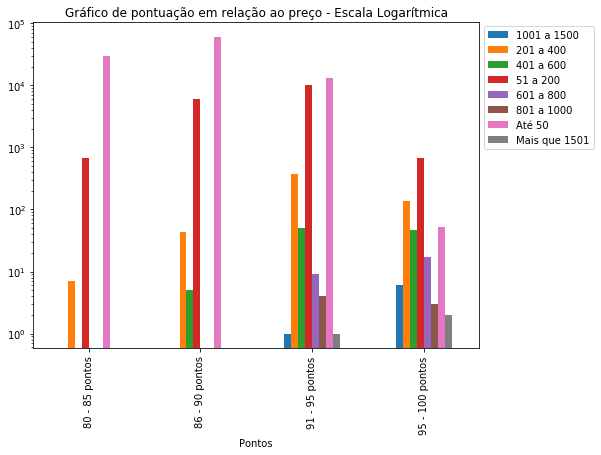

In [7]:
data = pd.crosstab(data_freq.Pontos, data_freq.Preço)
data.plot(kind='bar', figsize=(8,6));
plt.yscale('log')
plt.title("Gráfico de pontuação em relação ao preço - Escala Logarítmica")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.8));

Como é possível observar, vinhos com uma preço maior que 600 possuem pontuação maior que 91, enquanto vinhos mais baratos, com preço menor que 50, são só a maioria com 95 pontos pra baixo.

Podemos, junto a isso, fazer a correlação entre os pontos dados a um vinho e seu preço:

In [8]:
data_freq.points.corr(data_freq.price)

0.4600421512441059

Sendo que o resultado apresentado, 0.46, é umacorrelação média.

É possível ver também a quantidade de vinhos produzido por cada país:

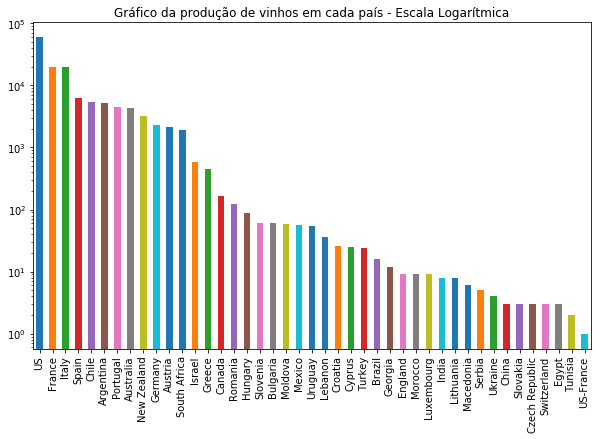

In [9]:
dfc_country = data_freq.country.value_counts()
dfc_country.plot(kind='bar', figsize=(10,6))
plt.yscale('log')
plt.title("Gráfico da produção de vinhos em cada país - Escala Logarítmica");

Sendo os Estados Unidos o maior produtor, seguido por países da Europa e América Central.

___
## C. MODELOS DE PREDIÇÃO

Primeiro, o Dataset é separado em TREINAMENTO e TESTE, além de separar a as variáveis em dependentes e idependentes

In [10]:
x = data_filtrado[['points', 'Aglianico', 'Albariño', 'Barbera',
       'Bordeaux-style Red Blend', 'Bordeaux-style White Blend',
       'Cabernet Franc', 'Cabernet Sauvignon', 'Carmenère', 'Champagne Blend',
       'Chardonnay', 'Chenin Blanc', 'Corvina, Rondinella, Molinara',
       'Dolcetto', 'Gamay', 'Garganega', 'Garnacha', 'Gewürztraminer', 'Glera',
       'Grenache', 'Grüner Veltliner', 'Malbec', 'Meritage', 'Merlot',
       'Montepulciano', 'Moscato', 'Nebbiolo', "Nero d'Avola", 'Petite Sirah',
       'Pinot Blanc', 'Pinot Grigio', 'Pinot Gris', 'Pinot Noir', 'Port',
       'Portuguese Red', 'Portuguese White', 'Prosecco', 'Red Blend',
       'Rhône-style Red Blend', 'Rhône-style White Blend', 'Riesling', 'Rosé',
       'Sangiovese', 'Sangiovese Grosso', 'Sauvignon Blanc', 'Shiraz',
       'Sparkling Blend', 'Syrah', 'Tempranillo', 'Tempranillo Blend',
       'Torrontés', 'Viognier', 'White Blend', 'Zinfandel']]
y = data_filtrado[['price']]

seed = 4935592

X_train, X_test, y_train, y_test = train_test_split(x, y, random_state = seed)

Assim, cada um dos modelos é trinado e testado e os resultados são colhidos para a comparação:

#### MODELO DE PREDIÇÃO PELA MÉDIA (Sem uso de variável explicativa).

In [11]:
media_price = np.mean(y.price)
print('A média dos preços dos vinhos é de R$ {0}'.format(media_price))

media_points = np.mean(x.points)
print('A média das notas dos vinhos é de {0} pontos'.format(media_points))

A média dos preços dos vinhos é de R$ 33.73283832103856
A média das notas dos vinhos é de 87.82248010823696 pontos


#### MODELO DOS K VIZINHOS MAIS PRÓXIMOS (K-Nearest Neighbors Regression)

In [12]:
erro = []
for k in range(1,5):
    clf = KNeighborsRegressor(k)
    clf.fit(X_train, y_train)
    y_pred_test_kviz = clf.predict(X_test)
    y_pred_train_kviz = clf.predict(X_train)
    erro.append(mean_squared_error(y_test,y_pred_test_kviz))
    

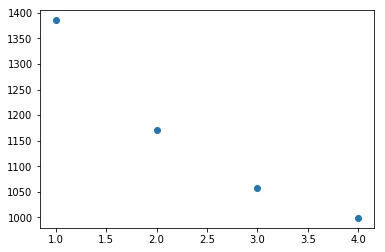

In [13]:
lista = [1,2,3,4]
plt.scatter(lista, erro);

In [14]:
clf = KNeighborsRegressor(3)
clf.fit(X_train, y_train)
print(mean_squared_error(y_test,y_pred_test_kviz))

print('Com K = 3, temos uma estabilização da medida de erro')

999.1368364043424
Com K = 3, temos uma estabilização da medida de erro


#### MODELO DE REGRESSÃO LINEAR (Multiple Linear Regression)

In [15]:
def regress(X,Y):
    X_cp = sm.add_constant(X)
    model = sm.OLS(Y,X_cp)
    results = model.fit()
    return results

In [16]:
y_pred_train_reg = regress(X_train, y_train)
y_pred_test_reg = regress(X_test, y_test)
y_pred_train_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.248
Model:                            OLS   Adj. R-squared:                  0.248
Method:                 Least Squares   F-statistic:                     579.8
Date:                Wed, 29 May 2019   Prob (F-statistic):               0.00
Time:                        05:13:21   Log-Likelihood:            -4.5603e+05
No. Observations:               93129   AIC:                         9.122e+05
Df Residuals:                   93075   BIC:                         9.127e+05
Df Model:                          53                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                          -388.7361      2.930   -132.669      0.000    -394.479    -382.993
points                            4.8626      0.034    142.927      0.000       4.796       4.929
Aglianico                        -8.9942      2.297     -3.915      0.000     -13.497      -4.492
Albariño                        -16.0985      1.601    -10.058      0.000     -19.236     -12.961
Barbera                          -9.7341      1.188     -8.193      0.000     -12.063      -7.405
Bordeaux-style Red Blend          6.1555      0.582     10.583      0.000       5.015       7.296
Bordeaux-style White Blend       -3.5892      1.541     -2.328      0.020      -6.610      -0.568
Cabernet Franc                   -4.1670      1.028     -4.052      0.000      -6.183      -2.151
Cabernet Sauvignon                2.7546      0.380      7.243      0.000       2.009       3.500
Carmenère                       -10.1492      1.352     -7.506      0.000     -12.799      -7.499
Champagne Blend                  31.1897      1.178     26.484      0.000      28.881      33.498
Chardonnay                       -5.6451      0.367    -15.403      0.000      -6.363      -4.927
Chenin Blanc                    -18.2921      1.478    -12.379      0.000     -21.188     -15.396
Corvina, Rondinella, Molinara     3.4640      1.060      3.267      0.001       1.386       5.542
Dolcetto                        -11.8358      2.048     -5.780      0.000     -15.849      -7.823
Gamay                           -17.6094      2.156     -8.167      0.000     -21.836     -13.383
Garganega                       -15.1652      2.060     -7.360      0.000     -19.204     -11.127
Garnacha                        -10.7984      1.844     -5.854      0.000     -14.414      -7.183
Gewürztraminer                  -13.3078      1.254    -10.612      0.000     -15.766     -10.850
Glera                           -13.3381      1.674     -7.968      0.000     -16.619     -10.057
Grenache                         -5.4506      1.494     -3.647      0.000      -8.380      -2.521
Grüner Veltliner                -15.9149      1.282    -12.413      0.000     -18.428     -13.402
Malbec                          -10.3039      0.687    -14.995      0.000     -11.651      -8.957
Meritage                         -0.3265      2.069     -0.158      0.875      -4.382       3.729
Merlot                           -4.1789      0.552     -7.570      0.000      -5.261      -3.097
Montepulciano                   -11.8317      2.202     -5.373      0.000     -16.147      -7.516
Moscato                         -12.8329      1.889     -6.795      0.000     -16.534      -9.131
Nebbiolo                         15.9293      0.973     16.371      0.000      14.022      17.836
Nero d'Avola                    -13.7176     

In [17]:
y_pred_test_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.265
Model:                            OLS   Adj. R-squared:                  0.264
Method:                 Least Squares   F-statistic:                     210.6
Date:                Wed, 29 May 2019   Prob (F-statistic):               0.00
Time:                        05:13:21   Log-Likelihood:            -1.5048e+05
No. Observations:               31043   AIC:                         3.011e+05
Df Residuals:                   30989   BIC:                         3.015e+05
Df Model:                          53                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                          -387.0702      4.823    -80.260      0.000    -396.523    -377.618
points                            4.8420      0.056     86.492      0.000       4.732       4.952
Aglianico                        -9.9078      3.743     -2.647      0.008     -17.245      -2.571
Albariño                        -15.4795      2.674     -5.790      0.000     -20.720     -10.239
Barbera                         -10.4415      2.009     -5.199      0.000     -14.378      -6.505
Bordeaux-style Red Blend          5.3493      0.964      5.550      0.000       3.460       7.239
Bordeaux-style White Blend        3.4459      2.510      1.373      0.170      -1.474       8.366
Cabernet Franc                   -3.5795      1.719     -2.082      0.037      -6.949      -0.210
Cabernet Sauvignon                2.3313      0.626      3.721      0.000       1.103       3.559
Carmenère                       -10.2127      2.259     -4.521      0.000     -14.640      -5.785
Champagne Blend                  29.9840      1.961     15.291      0.000      26.141      33.827
Chardonnay                       -4.6591      0.605     -7.706      0.000      -5.844      -3.474
Chenin Blanc                    -17.4578      2.358     -7.403      0.000     -22.080     -12.836
Corvina, Rondinella, Molinara     1.5916      1.638      0.971      0.331      -1.620       4.803
Dolcetto                        -11.7016      3.224     -3.630      0.000     -18.020      -5.383
Gamay                           -18.4005      3.399     -5.413      0.000     -25.064     -11.737
Garganega                       -15.8093      3.712     -4.259      0.000     -23.084      -8.534
Garnacha                        -10.9109      3.089     -3.532      0.000     -16.966      -4.856
Gewürztraminer                  -12.6665      2.009     -6.305      0.000     -16.604      -8.729
Glera                           -14.0130      2.852     -4.913      0.000     -19.603      -8.423
Grenache                         -4.9854      2.616     -1.906      0.057     -10.112       0.142
Grüner Veltliner                -17.7856      2.118     -8.396      0.000     -21.938     -13.633
Malbec                           -9.8523      1.133     -8.699      0.000     -12.072      -7.632
Meritage                          0.4908      3.421      0.143      0.886      -6.214       7.196
Merlot                           -5.3253      0.904     -5.891      0.000      -7.097      -3.554
Montepulciano                    -8.6923      3.858     -2.253      0.024     -16.254      -1.130
Moscato                         -13.6141      2.999     -4.540      0.000     -19.491      -7.737
Nebbiolo                         15.8735      1.571     10.103      0.000      12.794      18.953
Nero d'Avola                    -13.3235     

Como podemos analisar nos dados da regressão, o $P > |t|$ para as variáveis 'Bordeaux-style White Blend' , 'Meritage' e 'Tempranillo Blend' não são tão baixas, o que não nos permite rejeitar a hipótese nula, portanto seus betas são zero. Já para a probabilidade das variáveis restantes, podemos afirmar que se rejeita a hipótese nula, portanto seus respectivos betas são maiores que zero, considerando que as suas probabilidades foram baixas ou nulas.

#### MODELO DE ÁRVORES DE REGRESSÃO (Decision Tree Regression)

Para a árvore, é necessário: Treinar o programa, testar usando o dataframe $X_{test}$ e ver se o resultado é satisfatório

In [18]:
regressor = DecisionTreeRegressor(random_state = seed)
regressor.fit(X_train, y_train)

y_pred_train_tre = regressor.predict(X_train)
y_pred_test_tre = regressor.predict(X_test)

Para ter uma idéia da acurácia do programa, foi plotado um histograma com as diferenças entre o preço real e o predito no dataframe $X_{teste}$

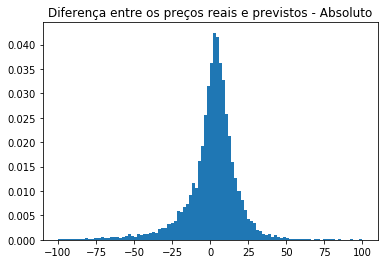

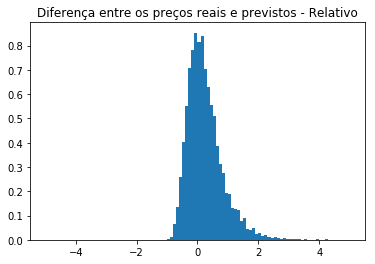

In [19]:
y_test_final=[]
for a in y_test.values:
    y_test_final.append(a[0])

y_test_final=np.array(y_test_final)
dif_abs = y_pred_test_tre - y_test_final
dif_rel = (y_pred_test_tre - y_test_final)/y_test_final

plt.hist(dif_abs, density = True, bins= 100, range=(-100,100));
plt.title("Diferença entre os preços reais e previstos - Absoluto")
plt.show();

plt.hist(dif_rel, density = True, bins= 100, range=(-5,5))
plt.title("Diferença entre os preços reais e previstos - Relativo")
plt.show();

___
## D. PROCESSO E ESTATÍSTICAS DE VALIDAÇÃO

Por fim, a eficácia é medida em cada modelo pelas fórmulas:

<img src="img/003c2e0e-26b4-4e73-8cea-6182eda838b2.png">

#### MODELO DE PREDIÇÃO PELA MÉDIA

In [20]:
z=0
b=0
for e in y_train.price:
    r= (e - media_price)**2
    z+=r

for e in y_test.price:
    rm= (e - media_price)**2
    b+=rm

RMS_train=(z/len(y_train))**(1/2)
RMS_test = (b/len(y_test))**(1/2)

print("RMS do Teste = {}\nRMS do Treinamento = {}" .format(RMS_test, RMS_train))

RMS do Teste = 35.951169128263956
RMS do Treinamento = 37.35294184436225


Nesse modelo $fi = ȳ$, portanto
$R²=0$

#### K-Nearest Neighbors Regression

In [21]:
t=0
s=0
z=0

for e in range(len(y_train.price)):
    rr=(y_train.iloc[e,0] - y_pred_train_kviz[e])**2
    t+=rr

for e in range(len(y_test.price)):
    re=(y_test.iloc[e,0] - y_pred_test_kviz[e])**2
    s+=re
    
for e in y_train.price:
    r= (e - y_train.price.mean())**2
    z+=r

RMS_test =(s/len(y_test))**(1/2)
RMS_train =(t/len(y_train))**(1/2)
r2=1 - t/z

print("RMS do Teste = {}\nRMS do Treinamento = {}\nR² = {}" .format(RMS_test.mean(), RMS_train.mean(), r2.mean()))

RMS do Teste = 31.609125840559756
RMS do Treinamento = 31.321015122971144
R² = 0.29689183696968124


#### MODELO DE REGRESSÃO LINEAR (Multiple Linear Regression)

In [22]:
# Tentativa Fracassada

# v=0
# d=0
# k=0

# for e in range(len(y_train.price)):
#     rr=(y_train.iloc[e,0] - y_pred_train_reg[e])**2
#     v+=rr

# for e in range(len(y_test.price)):
#     re=(y_test.iloc[e,0] - y_pred_test_reg[e])**2
#     d+=re
    
# RMS_test =(v/len(y_train))**(1/2)
# RMS_train =(d/len(y_test))**(1/2)

# print("RMS do Teste = {}\nRMS do Treinamento = {}" .format(RMS_test.mean(), RMS_train.mean()))

#### MODELO DE ÁRVORES DE REGRESSÃO (Decision Tree Regression)

In [23]:
ftr=0
gtr=0
ktr=0
for e in range(len(y_train.price)):
    rtr=(y_train.iloc[e,0] - y_pred_train_tre[e])**2
    ftr+=rtr

for e in range(len(y_test.price)):
    rtr=(y_test.iloc[e,0] - y_pred_test_tre[e])**2
    gtr+=rtr
    
for e in y_train.price:
    rtr= (e - y_train.price.mean())**2
    ktr+=rtr
    
RMS_test = (gtr/len(y_train))**(1/2)
RMS_train = (ftr/len(y_train))**(1/2)
r2=1 - ftr/ktr

print("RMS do Teste = {}\nRMS do Treinamento = {}\nR² = {}" .format(RMS_test, RMS_train, r2))

RMS do Teste = 16.29473339639252
RMS do Treinamento = 28.067876859645025
R² = 0.43536264491714005


___
## E. CONCLUSÃO

É possível comparar todos os dados em um dataframe:

In [24]:
Tabela = {'':['RMS Treinamento','RMS Teste','R²'],
    'Predição Pela Média': [37.35294184436225, 35.951169128263956,0],
    'K-Nearest Neighbors Regression': [31.321015122971144,31.609125840559756,0.29689183696968124],
    'Multiple Linear Regression': ['-','-',0.265],
    'Decision Tree Regression': [28.067876859645025,16.29473339639252,0.43536264491714005]}

df = pd.DataFrame(Tabela).set_index('')
df

,Predição Pela Média,K-Nearest Neighbors Regression,Multiple Linear Regression,Decision Tree Regression
,,,,
RMS Treinamento,37.352942,31.321015,-,28.067877
RMS Teste,35.951169,31.609126,-,16.294733
R²,0.000000,0.296892,0.265,0.435363


Tendo essa tabela como referência, é possível fazer algumas conclusões: o modelo mais explicativo, ou seja, o que é mais consolidado com as variáveis dadas (R²) é a Regressão pelo Modelo de Árvore, com $R² = 0.435363$, seguido pelo Modelo dos K Vizinhos mais Próximos, prela Regressão Linear Múltipla e pela predição pela média, nessa ordem. Além disso, apesar dos RMS da Regressão não serem alcançados neste projeto, ainda vale avaliar o dos outros modelos: o RMS da Predição pela Média e do modelo dos K Vizinhos mais Próximos indicam que ambos os modelos conseguem prever situações desconhecidas e conhecidas de maneira similar; Já o modelo da Árvore de Decisões possui uma maior eficácia na previsão de modelos desconhecidos, ainda assim, porém, prevendo tanto modelos novos como desconhecidos melhor que os outros modelos.
Assim, é possível, pelos dados obtidos, concluir que o modelo da Árvore de Regressão é o mais preciso e indicado nesse projeto.

___
## F. REFERÊNCIAS BIBLIOGRÁFICAS


https://ensinandomaquinasblog.wordpress.com/2017/12/15/modelos-preditivos-de-notas-de-redacao-do-enem-2015/


https://towardsdatascience.com/a-beginners-guide-to-linear-regression-in-python-with-scikit-learn-83a8f7ae2b4f